# Contents
Thank you for viewing this notebook.
Using WM-811K dataset, I will try image retrieval task. This notebook aims to implement the code with `PyTorch Metric Learning` library. This offers us the easiest way to build metric learning model and image search methods. 

You will find the simple and effective implementation!

### Preprocess(minimum)
WM-811K dataset containes the number of 811K data. However, there are only 25K data with specified labels. I will extract these with some other prerprocessing as well.

### Model, Dataset class definition
- Model: The most simple convnet with triplet loss
- Dataset: It returns X(torch.Tensor) and y(int). Yes, this is a kind of supervised learning.

### Train
With `trainer` API, I simply executed model training in metric learning way.

### Inference
- image retrieval with nearest neighbor search

### Some experiments

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wm811k-wafer-map/LSWMD.pkl


It's ok when you see the message,`/kaggle/input/wm811k-wafer-map/LSWMD.pkl`.  

上記実行後、`/kaggle/input/wm811k-wafer-map/LSWMD.pkl`と表記が出ればok

# Preprocessing, 前処理

In [2]:
import os
import warnings
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print(os.listdir("../input"))
warnings.filterwarnings("ignore")

['wm811k-wafer-map']


In [3]:
# It takes around 2 minutes on Kaggle notebook.
df = pd.read_pickle("../input/wm811k-wafer-map/LSWMD.pkl")
print(df.info())
display(df.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB
None


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]


In [4]:
# label extraction  e.g.)[Loc] → Loc　 @failureType, trianTestLabel column
f_squeeze = lambda x: str(np.squeeze(x))
df["failureType"] = df["failureType"].map(f_squeeze)
df["trianTestLabel"] = df["trianTestLabel"].map(f_squeeze)
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none


In [5]:
# drop the row data with no specified label
eliminate_list = ['none', '[]']
df_with_label = df.query(f"failureType not in {eliminate_list}")
print(f"{len(df_with_label)}")
print("Label list: ", df_with_label["failureType"].unique())
df_with_label.head(3)

25519
Label list:  ['Loc' 'Edge-Loc' 'Center' 'Edge-Ring' 'Scratch' 'Random' 'Near-full'
 'Donut']


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,Training,Loc
36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,Training,Edge-Loc
37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,Training,Edge-Loc


In [6]:
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3, 
    'Scratch': 4,
    'Random': 5, 
    'Near-full': 6,
    'Donut': 7
}
idx2class = {v: k for k, v in class2idx.items()}

# The following needs only when you want to save the dict above. Not always necessary.
class2idx_json_path = "./config_class2idx.json"
with open(class2idx_json_path, "w") as f:
    json.dump(class2idx, f)
# ↑保存終了

# New column → encoded_labels
df_with_label["encoded_labels"] = df_with_label["failureType"].replace(class2idx)

print(df_with_label["encoded_labels"].value_counts())
df_with_label.reset_index(inplace=True, drop=True)
df_with_label.to_pickle("./LSWMD_25519.pkl")  # ラベル有データ。ラベルエンコーディング等の前処理終わりデータになった。
df_with_label.head(3)

3    9680
1    5189
2    4294
0    3593
4    1193
5     866
7     555
6     149
Name: encoded_labels, dtype: int64


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,encoded_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,20.0,Training,Loc,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,12.0,Training,Edge-Loc,1
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,13.0,Training,Edge-Loc,1


In [7]:
train_data_length = int(0.8*len(df_with_label))  # training data for 80% of all data
df_with_label = df_with_label.sample(frac=1, random_state=2)
df_train, df_test = df_with_label[:train_data_length], df_with_label[train_data_length:]
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

train_data_length = int(0.7*len(df_train))  # Again, split the train data: train ⇨ train & val
df_train, df_val = df_train[:train_data_length], df_train[train_data_length:]
print(f"training: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}, (all: {len(df_with_label)})")

# This aims to save the data into your environment.
df_train.to_pickle("dataset_train.pickle")
df_val.to_pickle("dataset_val.pickle")
df_test.to_pickle("dataset_test.pickle")
print(os.listdir())

training: 14290, val: 6125, test: 5104, (all: 25519)
['config_class2idx.json', 'dataset_val.pickle', 'dataset_test.pickle', 'dataset_train.pickle', '__notebook__.ipynb', 'LSWMD_25519.pkl']


In [8]:
df_train.head(10)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,encoded_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1,...",515.0,lot32946,6.0,Training,Center,2
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3927.0,lot11171,20.0,Training,Edge-Ring,3
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1126.0,lot7741,1.0,Training,Random,5
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",1060.0,lot47461,9.0,Test,Center,2
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",13301.0,lot17294,1.0,Training,Scratch,4
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot40518,7.0,Test,Loc,0
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1291.0,lot11987,23.0,Training,Edge-Ring,3
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",741.0,lot44491,21.0,Test,Edge-Loc,1
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",12662.0,lot19855,24.0,Training,Edge-Ring,3
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",12662.0,lot17286,20.0,Training,Edge-Ring,3


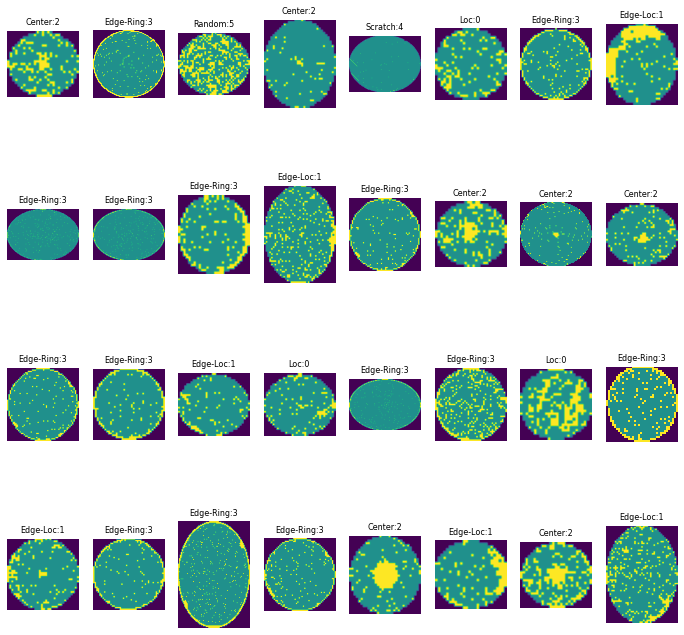

In [9]:
idx2class = {v: k for k, v in class2idx.items()}
batch_size = 32
plt.figure(figsize=(12,12))
for i in range(batch_size):
    ax = plt.subplot(4, 8, i+1)
    ax.axis("off")
    ax.imshow(df_train["waferMap"][i])
    ax.set_title(f'{idx2class[df_train["encoded_labels"][i]]}:{str(df_train["encoded_labels"][i])}', fontsize=8)

Preprocess ended! 前処理終了
# Model definition、Training
- Simple model definition 
- Implement with `pytorch-metric-learning` library

In [10]:
!pip install pytorch-metric-learning==1.6.2
# !pip install -q pytorch-metric-learning[with-hooks]
!pip install -q scanpy
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.4/111.4 kB 262.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 5.3 MB/s eta 0:00:00


In [11]:
from typing import Any, List
import torch
import torchvision
from torch import optim 
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
from pytorch_metric_learning import trainers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils import logging_presets
import cv2
import umap

In [12]:
# Dataset class definition
class WafermapTripletDataset(Dataset):
    def __init__(self, 
                 dataset_path: str = "",
                 column_name_apply_wafermap = "waferMap",
                 column_name_label: str = "encoded_labels",
                 resized_image_size: int = 80,
                 transforms: Any = None,
                 phase: str = "train"):
        super().__init__()
        self.__dict__.update(locals())  # 個人的にはあまり好きな書き方ではない。1つずつ定義を書いてもいいと思う。
        self._init_dataset()
        self.transforms = transforms
        self.phase = phase 
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        apply_wafermap, label = self.apply_wafer_maps[index], self.labels[index]
        if self.transforms:
            apply_wafermap = self.transforms(apply_wafermap, self.phase)
        else:
            pass
        apply_wafermap = apply_wafermap.to(torch.float32)

        return (apply_wafermap, label)

    def _init_dataset(self):
        self.df = pd.read_pickle(self.dataset_path).reset_index()
        self.labels = self.df[self.column_name_label]

        # modify wafermaps
        # apply image
        self.df[self.column_name_apply_wafermap] = self.df[self.column_name_apply_wafermap].apply(lambda x: cv2.resize(x, (self.resized_image_size, self.resized_image_size)))
        self.df[self.column_name_apply_wafermap] = self.df[self.column_name_apply_wafermap].apply(lambda x: np.repeat(x[..., np.newaxis], 1, -1))
        self.apply_wafer_maps = self.df[self.column_name_apply_wafermap].apply(lambda x: x.transpose((2,1,0)))  # inputの(バッチ、チャネル、たて、よこ)順番調整
        self.apply_wafer_maps = self.apply_wafer_maps + 1e-6
        self.apply_wafer_maps = self.apply_wafer_maps.apply(lambda x: torch.from_numpy(x))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc = nn.Linear(18432, 1152)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.dropout2(x)
        return x


class Embedder(nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()
        self.fc = nn.Linear(1152, 128)

    def forward(self, x):
        x = self.fc(x)
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the model
trunk = Net()
trunk = torch.nn.DataParallel(trunk.to(device))
embedder = Embedder()
embedder = torch.nn.DataParallel(embedder.to(device))
models = {"trunk": trunk, "embedder": embedder} 

# optimizer setting
trunk_optimizer = optim.Adam(trunk.parameters(), lr=0.01)
embedder_optimizer = optim.Adam(embedder.parameters(), lr=0.005)
optimizers = {"trunk_optimizer": trunk_optimizer, 
              "embedder_optimizer": embedder_optimizer}

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0) # 1対のペアごとにロスが計算されるが、揃ったものすべてを使うのではなく一定の閾値以上のものだけ使おうという処理。組み合わせ多いからかな。
loss = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
miner = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")  # ペアのうち、semihardとなるものを探す(=mining)機能。ここも調整の余地あり
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

# visual_hook implementation for result visualization
record_keeper, _, _ = logging_presets.get_record_keeper("logs", "tensorboard")  # ログ機能。logs, tensorboardフォルダを作って色々格納してくれるが本筋に影響なし
print(f"{record_keeper}")
hooks = logging_presets.get_hook_container(record_keeper)  # 学習イテレーションごとに追加処理を行うときに使う（embeddingをプロットしたい、）

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, epoch):
    class_labels = np.unique(labels)
    num_classes = len(class_labels)

    fig = plt.figure(figsize=(8, 6))
    colors = [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
    plt.gca().set_prop_cycle(cycler("color", colors))

    for i, lab in enumerate(class_labels):
        idx = labels == class_labels[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=3, label=lab) 

    plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    os.makedirs("result", exist_ok=True)
    plt.savefig(f"result/{epoch:02d}.png")
    plt.show()
    plt.close()

None


In [15]:
dataset_train_path = "./dataset_train.pickle"
dataset_val_path = "./dataset_train.pickle"
dataset_test_path = "./dataset_test.pickle"
train_dataset = WafermapTripletDataset(dataset_train_path, resized_image_size=28, column_name_apply_wafermap="waferMap")
val_dataset = WafermapTripletDataset(dataset_val_path, resized_image_size=28, column_name_apply_wafermap="waferMap")
test_dataset = WafermapTripletDataset(dataset_test_path, resized_image_size=28, column_name_apply_wafermap="waferMap")

In [16]:
# Tester definition
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook=hooks.end_of_testing_hook, 
                                            visualizer=umap.UMAP(), 
                                            visualizer_hook=visualizer_hook,
                                            dataloader_num_workers=4)

# Hook setting　→　1 epochごとにやってくれる処理をまとめるモジュールと考えればOK
dataset_dict = {"val": val_dataset}
model_dir = "./saved_models"
end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_dir, 
#                                             test_interval=1,   # depending on the PML version, this might be an error
#                                             patience=1,  # depending on the PML version, this might be an error
                                           )

# Model training
num_epochs = 50
batch_size = 48

# PML training API：trainer　⇒　モデル、ロス、最適化関数、データセットクラス、マイニング関数、等を与える
trainer = trainers.MetricLossOnly(models,
                                  optimizers,
                                  batch_size,
                                  loss_funcs,
                                  mining_funcs,
                                  train_dataset,
                                #   sampler=sampler,
                                  dataloader_num_workers=4,
                                  end_of_iteration_hook=hooks.end_of_iteration_hook,
                                  end_of_epoch_hook=end_of_epoch_hook)
trainer.train(num_epochs=num_epochs)

total_loss=0.01683: 100%|██████████| 297/297 [00:05<00:00, 55.83it/s]


In [17]:
# you can plot learning history, but it seems to depend on PML version. I am trying.

# loss_history = hooks.get_loss_history()
# plt.plot(loss_history["metric_loss"], "r", alpha=0.6, label="loss")
# plt.legend()

# Inference(Image Retrieval) 推論（画像検索）
- Load the model
- `InferenceModel`(pytorch-metric-learning module) ⇨ executes nearest neighbor search

In [18]:
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.utils import common_functions as c_f
from pytorch_metric_learning.utils.inference import InferenceModel, MatchFinder


# saved_trunk_path = "./saved_models/trunk_best1.pth"
# saved_embedder_path = "./saved_models/embedder_best1.pth"

# trunk = Net()
# trunk.load_state_dict(torch.load(saved_trunk_path))
# trunk.cpu()

# embedder = Embedder()
# embedder.load_state_dict(torch.load(saved_embedder_path))
# embedder.cpu()

match_finder = MatchFinder(distance=CosineSimilarity(), threshold=0.7)
inference_model = InferenceModel(trunk=trunk,
                                 embedder=embedder,
                                 match_finder=match_finder,
                                 data_device="cpu",
                                 )

In [19]:
# knn!(knn way nearest neighbor search)： This makes indices of the dataset
inference_model.train_knn(test_dataset)

In [20]:
# データセットクラスで定義したラベル（0－7）それぞれに対応するインデックスを取得できる
# PML offeres some utils function. You can get the data separated by labels.
labels_to_indices = c_f.get_labels_to_indices(test_dataset.labels)
# 試しにラベル3、ラベル６のインデックス集合をそれぞれ取得する
# For example, let's get the data with label 3 & 6
classA, classB = labels_to_indices[3], labels_to_indices[6]
img_type = classA   # ラベル3に対応するインデックスの集合(Data with label '3')

# 検索実行 Let's retrieve!
img, label = test_dataset[img_type[2]][0].unsqueeze(0), test_dataset[img_type[2]][1]
print(type(img), img.shape)

top_k = 10
distances, indices = inference_model.get_nearest_neighbors(img, k=top_k)
distances_list = list(distances.cpu().numpy()[0])
indices_list = list(indices.cpu().numpy()[0])

<class 'torch.Tensor'> torch.Size([1, 1, 28, 28])


In [21]:
print(f"top'{top_k}' index: ", indices_list)
df_result = test_dataset.df.iloc[indices_list, :]
df_result.head(10)

top'10' index:  [2, 3919, 4407, 1830, 2309, 4720, 2360, 4083, 4775, 18]


,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,encoded_labels
2,2,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1658.0,lot19814,13.0,Training,Edge-Ring,3
3919,3919,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1658.0,lot19814,14.0,Training,Edge-Ring,3
4407,4407,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1075.0,lot44162,16.0,Test,Edge-Ring,3
1830,1830,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1291.0,lot11987,25.0,Training,Edge-Ring,3
2309,2309,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1075.0,lot2503,4.0,Training,Edge-Ring,3
4720,4720,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1658.0,lot19814,21.0,Training,Edge-Ring,3
2360,2360,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1658.0,lot18375,8.0,Training,Edge-Ring,3
4083,4083,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1999.0,lot15009,2.0,Training,Edge-Ring,3
4775,4775,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1658.0,lot16606,20.0,Training,Edge-Ring,3
18,18,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1658.0,lot16600,16.0,Training,Edge-Ring,3


# Experiment Results, 実験結果
先ほどやったことを視覚化しながら再度実行してみる
- Comparison of query image and retrieved ones
- Visualize the embedding space(On kaggle notebook, it doesn't work. You can download it and try on the other environment)

Before preprocess:  <class 'numpy.ndarray'> (28, 28, 1)
After preprocess:  <class 'torch.Tensor'> torch.Size([1, 1, 28, 28])
top'10' index:  [4224, 1809, 2062, 1560, 4512, 4031, 3913, 468, 374, 2111]


,index,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,encoded_labels
0,4224,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1513.0,lot29454,11.0,Training,Scratch,4
1,1809,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",986.0,lot11553,18.0,Training,Loc,0
2,2062,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",776.0,lot40876,10.0,Test,Loc,0
3,1560,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1060.0,lot47458,11.0,Test,Loc,0
4,4512,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1800.0,lot6452,13.0,Training,Loc,0
5,4031,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",518.0,lot43980,10.0,Test,Loc,0
6,3913,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",562.0,lot46741,6.0,Test,Loc,0
7,468,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1129.0,lot42620,20.0,Test,Loc,0
8,374,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1256.0,lot43809,18.0,Test,Loc,0
9,2111,"[[[0], [0], [0], [0], [0], [0], [0], [0], [0],...",1485.0,lot43671,19.0,Test,Loc,0


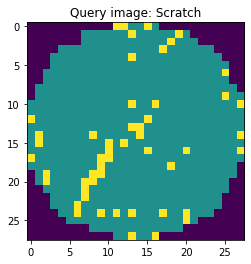

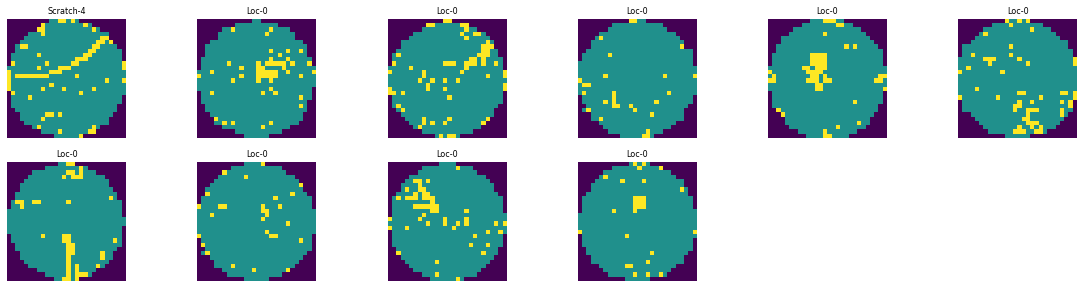

In [22]:
# クエリ情報の抜出 (ラベル１のデータを抜き出し、とりあえず最初の行にあるものをクエリとしてみる)
encoded_label = 4  # 自由に変えてトライ, Let's change.
df_tmp = test_dataset.df.query(f"encoded_labels=={encoded_label}").reset_index()
query, query_label = df_tmp["waferMap"][0], df_tmp["encoded_labels"][0]
print("Before preprocess: ", type(query), query.shape) # この時点ではnumpy.ndarrayになっている
plt.imshow(query)
plt.title(f"Query image: {idx2class[query_label]}")


# クエリ画像をモデルに入力するためのtorch用前処理
query = query.transpose(2,0,1) # shape:(a,b,c) → (c,a,b)
query = torch.from_numpy(query).float()
query = query.unsqueeze(0) # shape:(a,b,c) → (1,a,b,c) のように1を追加。PyTorchのお作法（バッチ次元）
print("After preprocess: ", type(query), query.shape) # この時点ではtorch.Tensorになっている
assert isinstance(query, torch.Tensor)

# Search! 実験（検索実行！）
top_k = 10
distances, indices = inference_model.get_nearest_neighbors(query, k=top_k)
distances_list = list(distances.cpu().numpy()[0])
indices_list = list(indices.cpu().numpy()[0])

print(f"top'{top_k}' index: ", indices_list)
df_result = test_dataset.df.iloc[indices_list, :].reset_index(drop=True)


# Visualize results. 結果表示
display(df_result.head(10))
plt.figure(figsize=(16,16))
for i in range(top_k):
    ax = plt.subplot(8, 6, i+1)
    ax.axis("off")
    ax.imshow(df_result["waferMap"][i])
    ax.set_title(f'{idx2class[df_result["encoded_labels"][i]]}-{str(df_result["encoded_labels"][i])}', 
                 fontsize=8,
                )
plt.tight_layout()
plt.show()

# 以上,結果のまとめと今後とるべき対策
- クエリに対して画像の検索を実施した
- クエリに対して検索上位に出てきたものは似てるものだけではなかった。
    * 学習器を変える
    * 画像毎のサイズ違いに注意する
    * augmentationする

## 発展的知識
- プロダクション上では一般に検索DBが大きくなりやすい（桁違いに大きくなる）
- クエリの特徴量抽出は特徴抽出器のサイズ依存だが、検索は「検索手法依存」となる
- 検索には一定の高速性が求められるため、「検索手法」の工夫が世の中にはたくさんある
    * 全探索手法
    * 最近傍探索手法
    * 近似最近傍探索手法
    * 様々な後処理手法（検索結果を出したのち、その中で再度何かしら計算を行い精度を高める）
- 画像検索は「クエリと似たものは何か？」を探すタスクであり、学習時にないデータを推論する（=検索する）ことに使う
- metric learningは学習データの**相対的な位置関係**をロス関数にして学習しており、顔認証や画像検索タスクに用いられることで知られる（世の中のどのシステムに具体的に導入されてるかは把握してません）
- 画像検索コンペの最上位でもmetric learningは未だに使用されており、工夫はいるが強力な手法である

# 以下、ちょっとわからないこと出たのでやりません。機能だけ紹介します。

再度掲載- クラスと対応番号
```
class2idx = {
    'Loc': 0,
    'Edge-Loc': 1,
    'Center': 2,
    'Edge-Ring': 3, 
    'Scratch': 4,
    'Random': 5, 
    'Near-full': 6,
    'Donut': 7
}
```

In [23]:
# データセットクラスで定義したラベル（0－7）それぞれに対応するインデックスを取得できる
labels_to_indices = c_f.get_labels_to_indices(train_dataset.labels)
# 試しにラベル１、ラベル６のインデックス集合をそれぞれ取得する
classA, classB = labels_to_indices[3], labels_to_indices[9]
img_type = classA   # ラベル3に対応するインデックスの集合

# 検索実行
img, label = test_dataset[img_type[2]][0].unsqueeze(0), test_dataset[img_type[2]][1]
print(type(img), img.shape)
# distances, indices = inference_model.get_nearest_neighbors(img, k=10)

print(classA)

<class 'torch.Tensor'> torch.Size([1, 1, 28, 28])
[    1     6     8 ... 14286 14287 14288]


In [24]:
print(indices.cpu().numpy())
print(indices.cpu().numpy()[0].shape)

[[4224 1809 2062 1560 4512 4031 3913  468  374 2111]]
(10,)


torch.Size([1, 28, 28]) torch.Size([1, 28, 28])


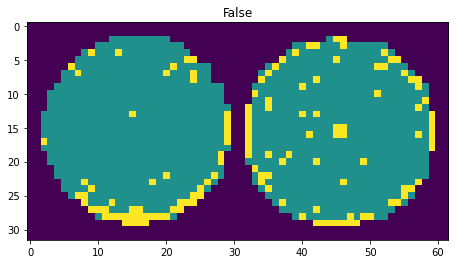

Different class


In [25]:
def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]

# inv_normalize = transforms.Normalize(
#     mean=[-m / s for m, s in zip(mean, std)], std=[1 / s for s in std]
# )
def imshow(img, title=None, figsize=(8, 4)):
    # img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0))[:,:,0])
    plt.title(title)
    plt.show()

# compare two images of the same class
(x, _), (y, _) = test_dataset[classA[0]], test_dataset[classA[1]]
print(x.shape, y.shape)
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
stack_image = torch.stack([x, y], dim=0)  # double torch.Size([20, 1, 28, 28]) -> torch.Size([2, 20, 1, 28, 28])
imshow(torchvision.utils.make_grid(stack_image), title=decision)
print_decision(decision)